In [85]:
from typing import Literal

import numpy as np
import pandas as pd
import requests
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from pykeen.predict import predict_target
from pykeen.triples import TriplesFactory

In [81]:
DECISIVE_METRIC = 'arithmetic_mean_rank'
DECISIVE_METRIC_OPTIMUM = 'min'

# Set Seaborn theme
SEABORN_THEME = 'darkgrid'
sns.set_theme(style=SEABORN_THEME)

In [3]:
SubsetType = Literal['train', 'valid', 'test']

def load_wikidata5m_dataset(subset_type: SubsetType):
    return pd.read_csv(f'dataset/wikidata5m/wikidata5m_transductive_{subset_type}.txt', sep='\t', names=['S', 'P', 'O'])

wikidata5m_train = load_wikidata5m_dataset('train')
wikidata5m_valid = load_wikidata5m_dataset('valid')
wikidata5m_test = load_wikidata5m_dataset('test')

In [4]:
def get_trained_models():
    return {
        'complex': torch.load('embeddings/dim_32/complex/trained_model.pkl'),
        'distmult': torch.load('embeddings/dim_32/distmult/trained_model.pkl'),
        'simple': torch.load('embeddings/dim_32/simple/trained_model.pkl'),
        'transe': torch.load('embeddings/dim_32/transe/trained_model.pkl')
    }


def get_trained_entity_mappings():
    return {
        'complex': TriplesFactory.from_path_binary('embeddings/dim_32/complex/training_triples'),
        'distmult': TriplesFactory.from_path_binary('embeddings/dim_32/distmult/training_triples'),
        'simple': TriplesFactory.from_path_binary('embeddings/dim_32/simple/training_triples'),
        'transe': TriplesFactory.from_path_binary('embeddings/dim_32/transe/training_triples')
    }

trained_models = get_trained_models()
entity_mappings = get_trained_entity_mappings()

In [76]:
dim32_predicate_metrics = pd.read_csv('metrics/predicate_metrics.csv')

# Only consider realistic values, evaluated on both ends
dim32_predicate_metrics = dim32_predicate_metrics.query('Type == "realistic" and Side == "both"')

In [6]:
def get_wikidata_property_labels(property_ids: list) -> dict:
    wikidata_api = 'https://www.wikidata.org/w/api.php'
    params = {
        'action': 'wbgetentities',
        'ids': '|'.join(property_ids),
        'languages': 'en',
        'props': 'labels',
        'format': 'json'
    }

    response = requests.get(wikidata_api, params).json()

    property_labels = []
    for pid in property_ids:
        property_labels.append(response['entities'][pid]['labels']['en']['value'])

    return property_labels

In [77]:
def find_train_triple_with_predicate(predicate_name):
    triples = wikidata5m_train.query('P == @predicate_name')
    
    if len(triples) > 0:
        first_triple = tuple(triples.iloc[0][['S', 'P', 'O']])
        return first_triple
    else:
        print(f'Error: No triples found for predicate {predicate_name} in training set')
    
    
def find_train_triple_with_subject(subject_name):
    triples = wikidata5m_train.query('S == @subject_name')
    
    if len(triples) > 0:
        first_triple = tuple(triples.iloc[0][['S', 'P', 'O']])
        return first_triple
    else:
        print(f'Error: No triples found for subject {subject_name} in training set')


def select_best_model(predicate_metrics, predicate_name):
    metrics_df = predicate_metrics.query('Metric == @DECISIVE_METRIC and relation_label == @predicate_name')
    
    optimal_metric = None
    if DECISIVE_METRIC_OPTIMUM == 'min':
        optimal_metric = metrics_df.loc[metrics_df['Value'].idxmin()]
    elif DECISIVE_METRIC_OPTIMUM == 'max':
        optimal_metric = metrics_df.loc[metrics_df['Value'].idxmax()]
        
    return optimal_metric['model']


def predict_tail(model_name, subject, predicate):
    model = trained_models[model_name]
    triples_factory = entity_mappings[model_name]
    
    return predict_target(
        model=model,
        head=subject,
        relation=predicate,
        tail=None,
        triples_factory=triples_factory
    )


def format_triple(subject, predicate, obj):
    return f'{subject} {predicate} {obj}   {get_wikidata_property_labels([subject, predicate, obj])}'


# Remove the entity already present in the triple
# from the predictions (e.g. the subject when the
# object is being predicted)
def filter_predictions(predictions, src_entity, train_factory):
    predictions = predictions.add_membership_columns(train=train_factory, valid=wikidata5m_valid, test=wikidata5m_test)
    predictions_df = predictions.df.query('tail_label != @src_entity')
    return predictions_df.sort_values(by='score', ascending=False)

## Best Model Counts

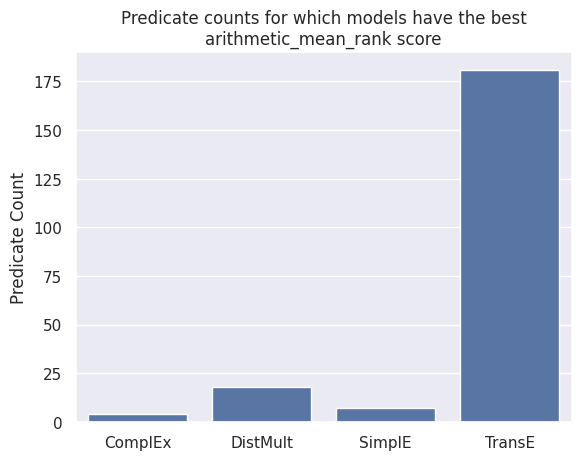

In [89]:
def compute_best_model_counts(predicate_metrics):
    predicate_metrics = predicate_metrics.query('Metric == @DECISIVE_METRIC')
    
    model_counts = {
        'complex': 0,
        'distmult': 0,
        'simple': 0,
        'transe': 0
    }
    for predicate_name, metrics_df in predicate_metrics.groupby(by='relation_label'):
        best_model = select_best_model(metrics_df, predicate_name)
        model_counts[best_model] += 1
        
    return pd.Series(model_counts)


def plot_best_model_counts(model_counts, embedding_dim=32):
    sns.set_theme(style=SEABORN_THEME)
    
    model_labels = ['ComplEx', 'DistMult', 'SimplE', 'TransE']
    if 'complex' not in model_counts.index.values:
        model_labels = ['DistMult', 'SimplE', 'TransE']
    
    # Plot best model counts
    ax = sns.barplot(data=model_counts)
    ax.set_title(f'Predicate counts for which models have the best\n{DECISIVE_METRIC} score')
    ax.set_ylabel('Predicate Count')
    ax.set_xticks(np.arange(len(model_labels)))
    ax.set_xticklabels(model_labels)
    
    plt.show()
        

best_model_counts = compute_best_model_counts(dim32_predicate_metrics)
plot_best_model_counts(best_model_counts)

## First Triple Prediction

In [65]:
start_predicate = 'P106'  # shares border with
s1, p1, o1 = find_train_triple_with_predicate(start_predicate)
print(f'Triple Pattern:  {s1} {p1} ?o1')
print('Original triple:', format_triple(s1, p1, o1))

best_model = select_best_model(dim32_predicate_metrics, p1)
print('Best model:', best_model)

Triple Pattern:  Q14573913 P106 ?o1
Original triple: Q14573913 P106 Q189290   ['W. W. Behrens', 'occupation', 'military officer']
Best model: transe


In [66]:
first_predictions = predict_tail(best_model, subject=s1, predicate=p1)
first_predictions = filter_predictions(first_predictions, s1, train_factory=entity_mappings[best_model]).head()
first_predictions

You're trying to map triples with 180 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 180 from 5163 triples were filtered out
You're trying to map triples with 156 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 156 from 5133 triples were filtered out


,tail_id,score,tail_label,in_train,in_valid,in_test
4527869,4527869,-5.749949,Q921792,False,False,False
3691575,3691575,-5.759833,Q683754,False,False,False
4077301,4077301,-5.770157,Q7497964,False,False,False
1191280,1191280,-5.848825,Q2064949,False,False,False
1008469,1008469,-5.851713,Q18636088,False,False,False


In [67]:
pred_o1 = first_predictions.iloc[0]['tail_label']
print(f'?o1 -> {pred_o1}  {get_wikidata_property_labels([pred_o1])}')
print('Predicted triple:', format_triple(s1, p1, pred_o1))

?o1 -> Q921792  ['Kingsville Township']
Predicted triple: Q14573913 P106 Q921792   ['W. W. Behrens', 'occupation', 'Kingsville Township']


## Second Triple Prediction

In [68]:
s2, p2, o2 = find_train_triple_with_subject(pred_o1)
print(f'Triple Pattern:  {s2} {p2} ?o2')
print('Original triple:', format_triple(s2, p2, o2))

best_model = select_best_model(dim32_predicate_metrics, p2)
print('Best model:', best_model)

Triple Pattern:  Q921792 P131 ?o2
Original triple: Q921792 P131 Q336322   ['Kingsville Township', 'located in the administrative territorial entity', 'Ashtabula County']
Best model: transe


In [69]:
second_predictions = predict_tail(best_model, subject=s2, predicate=p2)
second_predictions = filter_predictions(second_predictions, s2, train_factory=entity_mappings[best_model]).head()
second_predictions

You're trying to map triples with 180 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 180 from 5163 triples were filtered out
You're trying to map triples with 156 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 156 from 5133 triples were filtered out


,tail_id,score,tail_label,in_train,in_valid,in_test
2648630,2648630,-4.815659,Q490757,False,False,False
319623,319623,-4.848046,Q1371,False,False,False
171360,171360,-4.869611,Q1199,False,False,False
341457,341457,-4.875599,Q1400,False,False,False
3345380,3345380,-4.938412,Q61315,False,False,False


In [70]:
pred_o2 = second_predictions.iloc[0]['tail_label']
print(f'?o2 -> {pred_o2}  {get_wikidata_property_labels([pred_o2])}')
print('Predicted triple:', format_triple(s2, p2, pred_o2))

?o2 -> Q490757  ['Carroll County']
Predicted triple: Q921792 P131 Q490757   ['Kingsville Township', 'located in the administrative territorial entity', 'Carroll County']


## Third Triple Prediction

In [71]:
s3, p3, o3 = find_train_triple_with_subject(pred_o2)
print(f'Triple Pattern:  {s3} {p3} ?o3')
print(f'Original triple:', format_triple(s3, p3, o3))

best_model = select_best_model(dim32_predicate_metrics, p3)
print('Best model:', best_model)

Triple Pattern:  Q490757 P17 ?o3
Original triple: Q490757 P17 Q30   ['Carroll County', 'country', 'United States of America']
Best model: transe


In [72]:
third_predictions = predict_tail(best_model, subject=s3, predicate=p3)
third_predictions = filter_predictions(third_predictions, s3, train_factory=entity_mappings[best_model]).head()
third_predictions

You're trying to map triples with 180 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 180 from 5163 triples were filtered out
You're trying to map triples with 156 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 156 from 5133 triples were filtered out


,tail_id,score,tail_label,in_train,in_valid,in_test
3070120,3070120,-5.605819,Q55,False,False,False
2993704,2993704,-5.668486,Q5385,False,False,False
4132676,4132676,-5.781371,Q760,False,False,False
2841381,2841381,-5.851366,Q518101,False,False,False
410797,410797,-5.882351,Q148,False,False,False


In [73]:
pred_o3 = third_predictions.iloc[0]['tail_label']
print(f'?o3 -> {pred_o3}  {get_wikidata_property_labels([pred_o3])}')
print('Predicted triple:', format_triple(s3, p3, pred_o3))

?o3 -> Q55  ['Netherlands']
Predicted triple: Q490757 P17 Q55   ['Carroll County', 'country', 'Netherlands']
